In [1]:
from livelossplot import PlotLossesKeras
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
#import seaborn as sns
import cv2
import random
import shutil
import pathlib

%matplotlib inline

np.random.seed(100)

batch_size = 64
image_side_size = 150

target_size = (image_side_size, image_side_size)

Using TensorFlow backend.


# Prepare data


There are 9850 total images.

Trainable...
There are 996 total classes.
There are 2300 training actual images.
There are 1152 validation actual images.
There are 1300 test actual images.
After data filtering
               Image         Id
count           4752       4752
unique          4752        996
top     c75f810f.jpg  w_1287fbc
freq               1         34

Under represented targets
               Image         Id
count           4288       4288
unique          4288       3254
top     39e08807.jpg  w_d20befa
freq               1          2


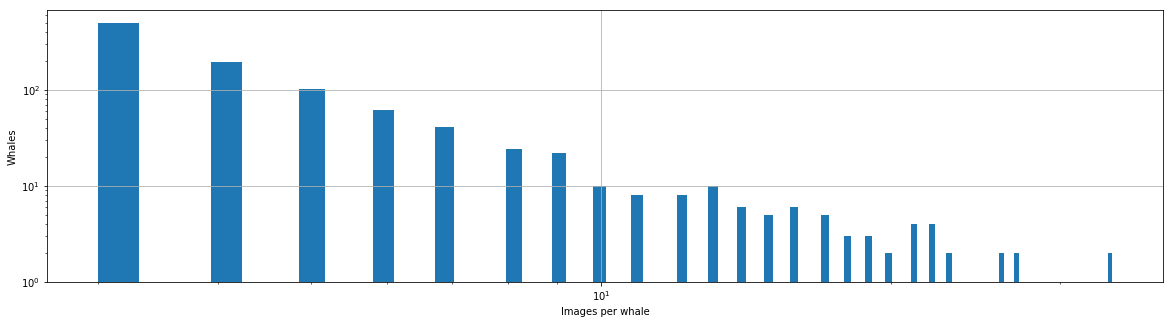

In [2]:
df = pd.read_csv("train.csv", header = 0)

total_images = len(df)

# drop rows with new_whale because it is used to label various unknown flukes yet
df = df[df.Id != 'new_whale']

image_threshhold = 3

# under represented targets
df_under_targets = df.groupby("Id").filter(lambda x: len(x) < image_threshhold)

# use targets with image_threshhold+ samples
df = df.groupby("Id").filter(lambda x: len(x) >= image_threshhold)

value_counts = df.Id.value_counts()

top_hitters = value_counts.nlargest(10).index

# Use top N targets by image count
#df = df[df['Id'].isin(top_hitters)]

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Whales")
ax.set_xlabel("Images per whale")
value_counts.hist(ax=ax, figsize=(20,5), bins=100, bottom=1)

classes = df.Id.unique()
num_classes = len(classes)

X_train = []; y_train = []

X_test = []; y_test = []

X_valid = []; y_valid = []

for whale_id in classes:
    df_whale = df[df.Id == whale_id]
    
    X_whale = np.array([os.path.join(os.getcwd(), 'train', s) for s in df_whale.Image])
    y_whale = np.array(df_whale.Id.values)
    
    X_train_whale, X_test_whale, y_train_whale, y_test_whale = \
        train_test_split(X_whale, y_whale, test_size=0.2, random_state=1)
    X_test.extend(X_test_whale)
    y_test.extend(y_test_whale)
    
    X_train_whale, X_valid_whale, y_train_whale, y_valid_whale = \
        train_test_split(X_train_whale, y_train_whale, test_size=0.2, random_state=1)
    X_train.extend(X_train_whale)
    y_train.extend(y_train_whale)
    X_valid.extend(X_valid_whale)
    y_valid.extend(y_valid_whale)

print('\nThere are %d total images.' % total_images)
print("\nTrainable...")
print('There are %d total classes.' % num_classes)

print('There are %d training actual images.' % len(X_train))
print('There are %d validation actual images.' % len(X_valid))
print('There are %d test actual images.' % len(X_test))

print("After data filtering")
print(df.describe())

print("\nUnder represented targets")
print(df_under_targets.describe())

# Simulate under represented images

In [3]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

augmented_path = './augmented'

if not os.path.exists(augmented_path):

    pathlib.Path(augmented_path).mkdir(parents=True)

    for index, row in df_under_targets.iterrows():
        file = row['Image']
        id = row['Id']

        img = load_img(f'train/{file}')
        img = img_to_array(img) 
        img = img.reshape((1,) + img.shape)

        # the .flow() command below generates batches of randomly transformed images
        i = 0
        for batch in datagen.flow(img,
                                  batch_size=1,
                                  save_to_dir=augmented_path, 
                                  save_prefix=f'{id}', 
                                  save_format='jpeg'):
            i += 1
            if i > 5:
                break  # otherwise the generator would loop indefinitely

# Build labeled list of augmented images for training

In [4]:
import glob
import csv
import ntpath

augmented_file = 'train_augmented.csv'

if not os.path.isfile(augmented_file): 
    with open('train_augmented.csv', 'w') as csvfile:
        fieldnames = ['Image', 'Id']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        augmented_list = glob.glob(f'{augmented_path}/*.jpeg')

        for file in augmented_list:
            base_name = os.path.basename(file)
            writer.writerow(dict(zip(fieldnames,[base_name, "_".join(base_name.split("_", 2)[:2])])))

# Distribute augmented files across labels

In [5]:
df_augmented = pd.read_csv("train_augmented.csv", header = 0)

total_augmented_images = len(df_augmented)

classes_augmented = df_augmented.Id.unique()
num_augmented_classes = len(classes_augmented)

for whale_id in classes_augmented:
    df_whale = df_augmented[df_augmented.Id == whale_id]
    
    X_whale = np.array([os.path.join(os.getcwd(), augmented_path, s) for s in df_whale.Image])
    y_whale = np.array(df_whale.Id.values)
    
    X_train_whale, X_test_whale, y_train_whale, y_test_whale = \
        train_test_split(X_whale, y_whale, test_size=0.2, random_state=1)
    X_test.extend(X_test_whale)
    y_test.extend(y_test_whale)
    
    X_train_whale, X_valid_whale, y_train_whale, y_valid_whale = \
        train_test_split(X_train_whale, y_train_whale, test_size=0.2, random_state=1)
    X_train.extend(X_train_whale)
    y_train.extend(y_train_whale)
    X_valid.extend(X_valid_whale)
    y_valid.extend(y_valid_whale)

print('\nThere are %d total augmented images.' % total_augmented_images)
print('There are %d total augmented classes.' % num_augmented_classes)

print('There are %d training images.' % len(X_train))
print('There are %d validation images.' % len(X_valid))
print('There are %d test images.' % len(X_test))

num_classes += num_augmented_classes
print('There are %d total classes.' % num_classes)


There are 25713 total augmented images.
There are 3254 total augmented classes.
There are 16189 training images.
There are 5440 validation images.
There are 8836 test images.
There are 4250 total classes.


# Visualize 12 random training images

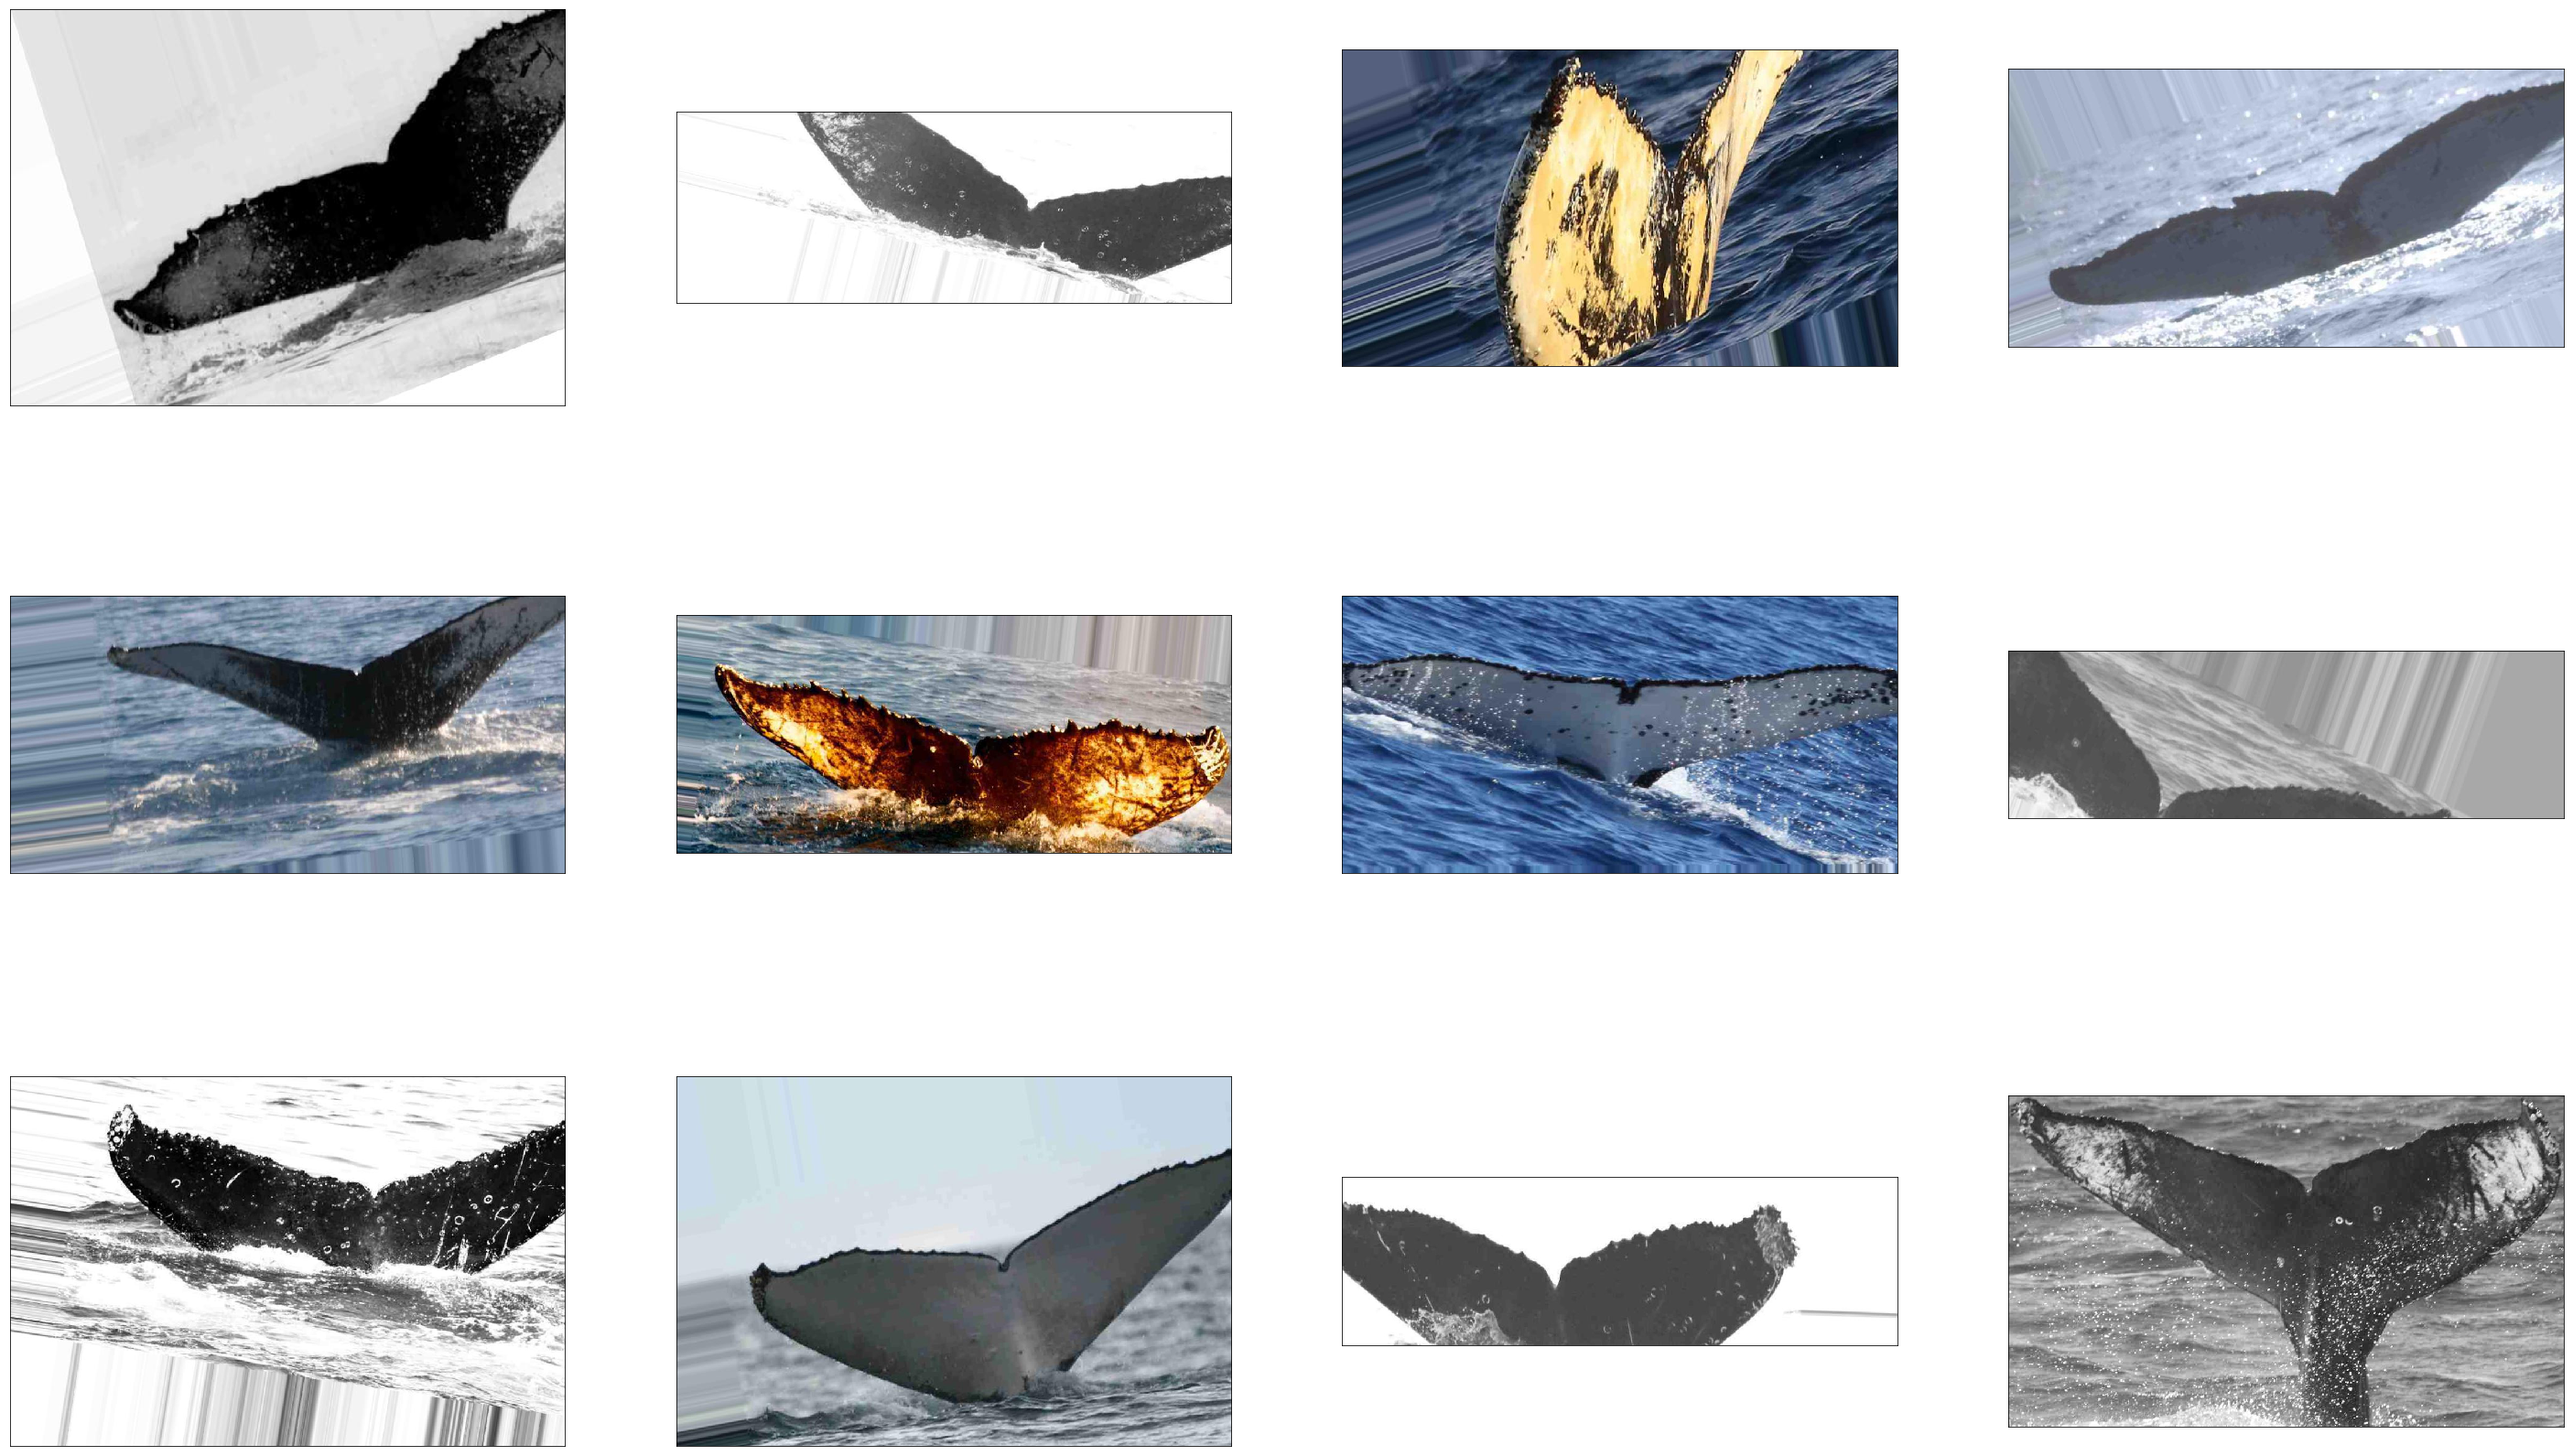

In [6]:
def visualize_img(img_path, ax):
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(50, 30))

num_images = 12
rand_images = random.sample(X_train, num_images)

for i, file in enumerate(rand_images):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    visualize_img(file, ax)

# Visualize random whale from a top hitter

['w_987a36f']


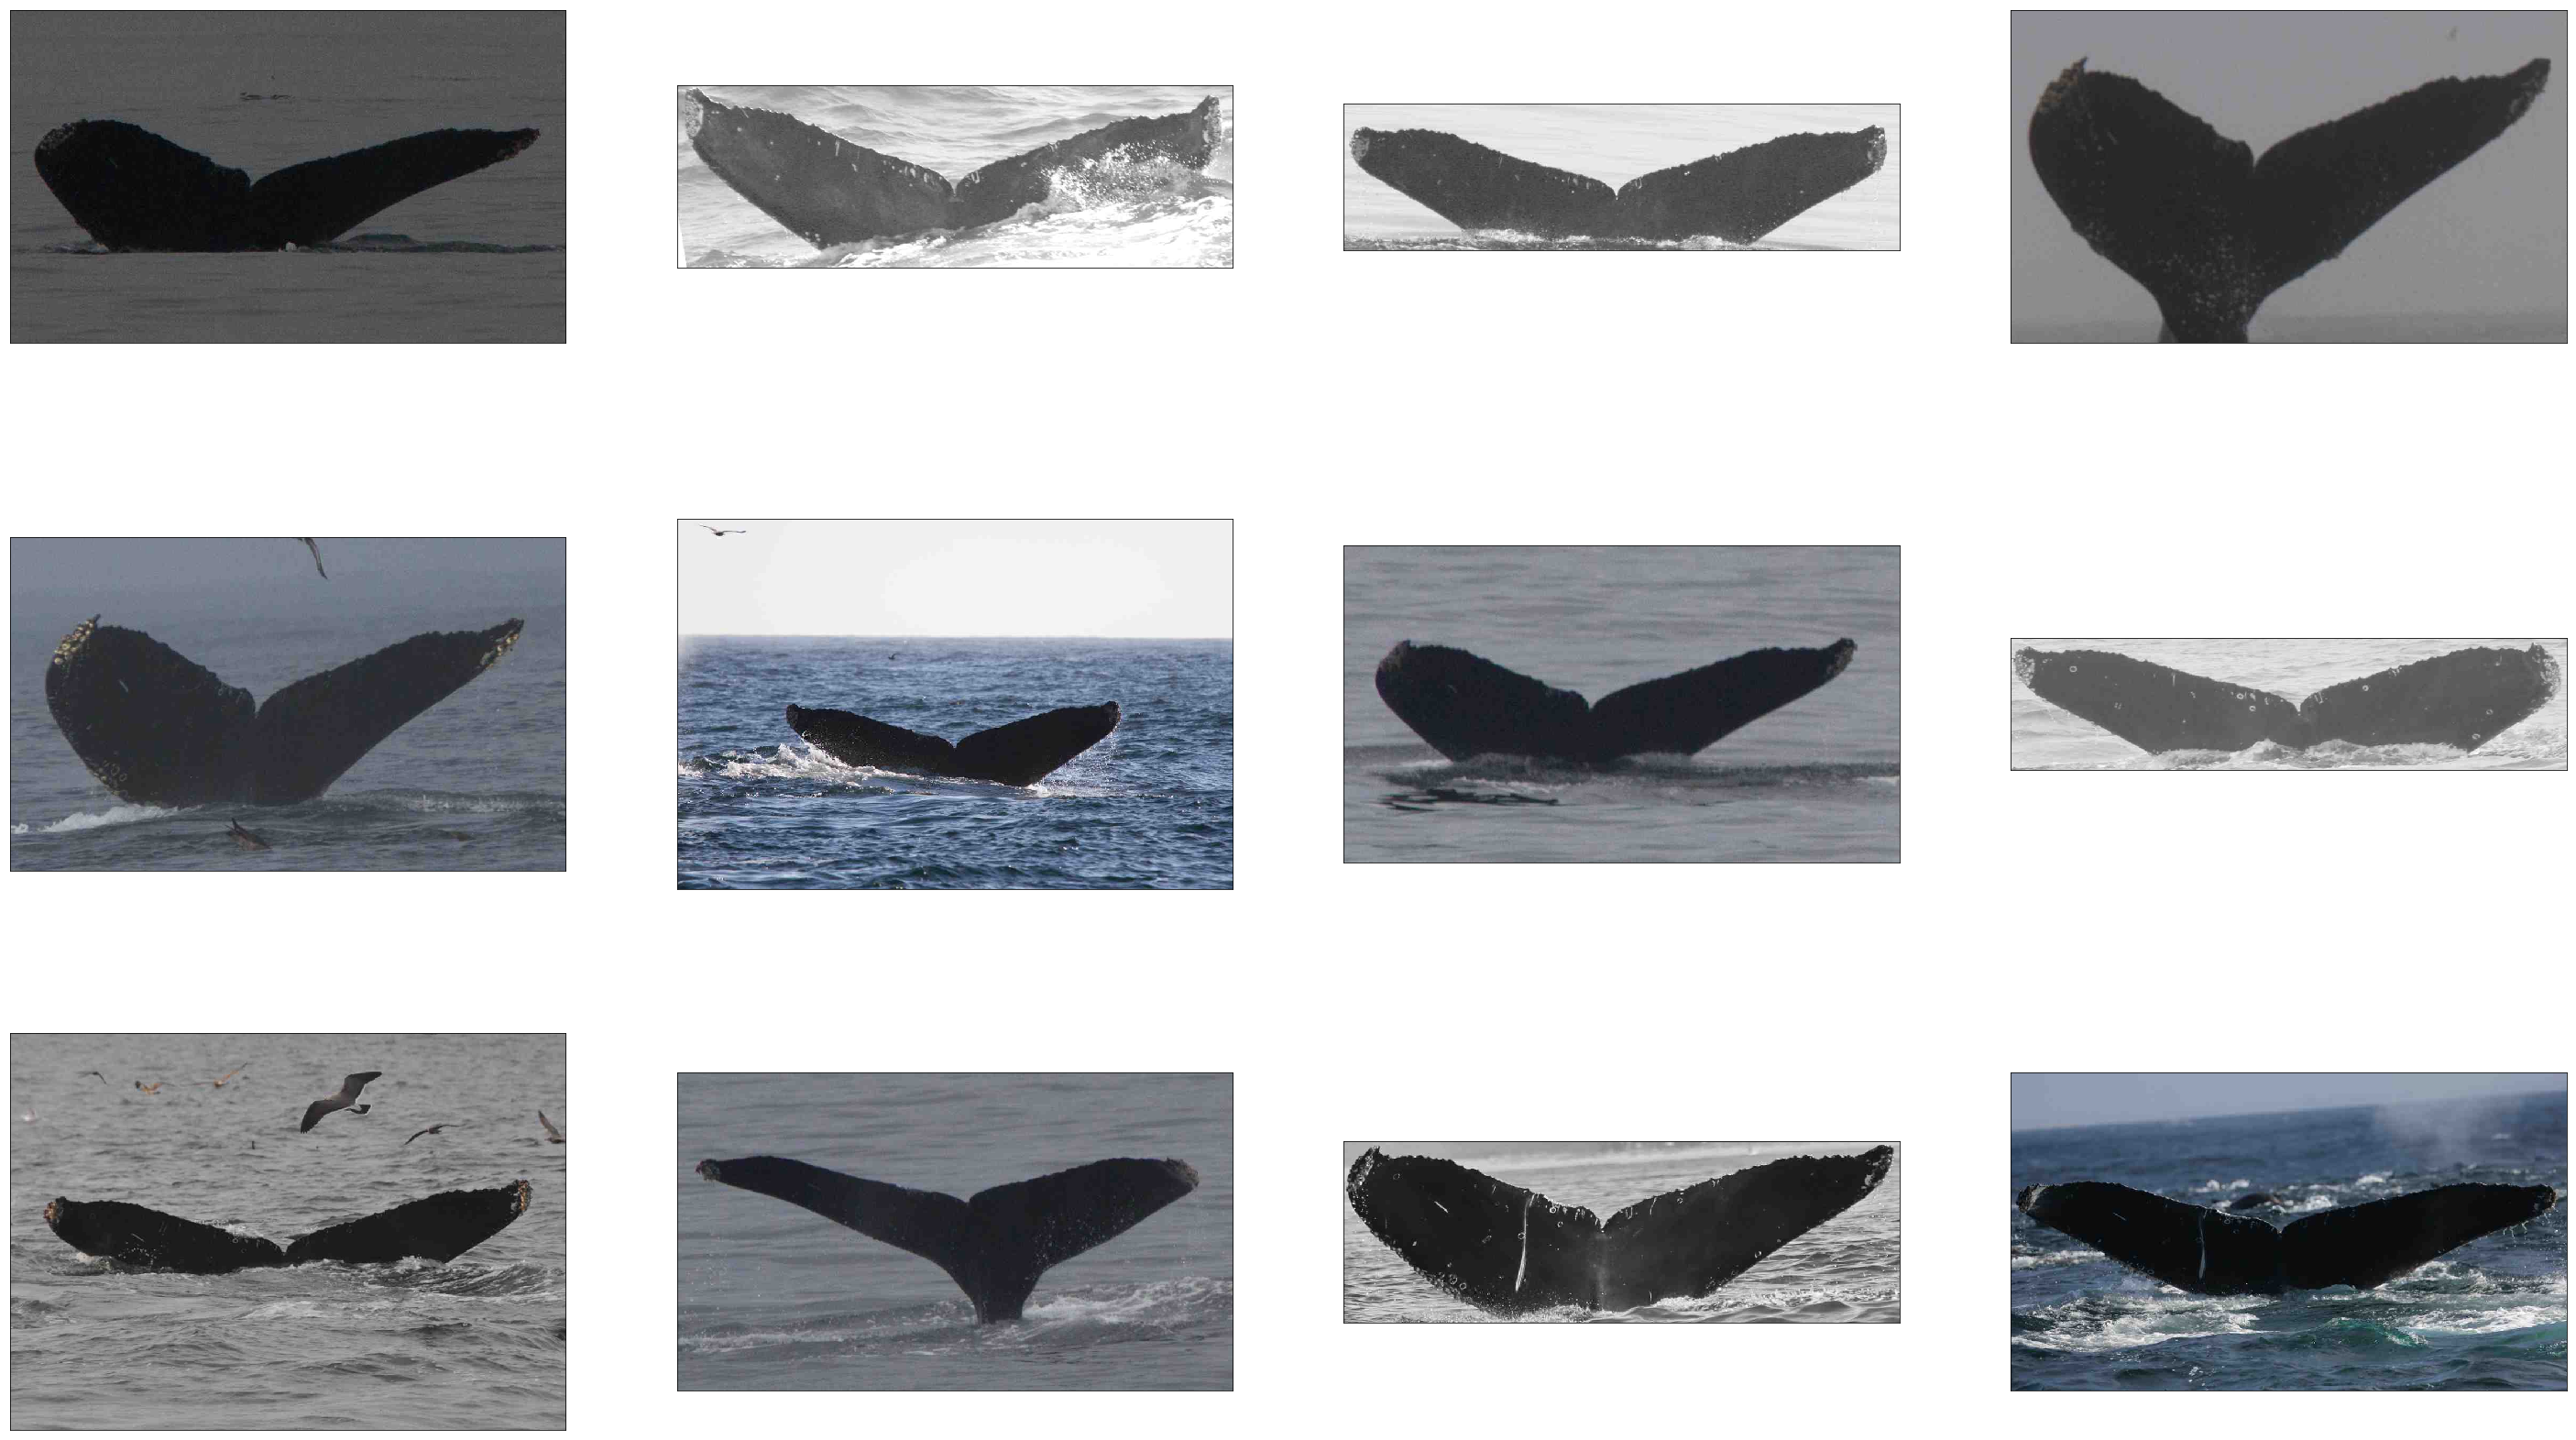

In [7]:
random_whale = random.sample(list(top_hitters),1)
print(random_whale)

whale_images = list(df[df['Id'].isin(random_whale)]['Image'])
files = [s for s in X_train if any(w in s for w in whale_images)]

fig = plt.figure(figsize=(50, 30))

for i, file in enumerate(files[:12]):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    visualize_img(file, ax)

# Prepare Dataset for ImageDataGenerator

In [8]:
def copy_class_of_files(files, dst, labels):
    for idx, val in enumerate(files):
        dst_dir = os.path.join(dst, labels[idx])
        pathlib.Path(dst_dir).mkdir(parents=True, exist_ok=True)
        shutil.copy(val, dst_dir)
        
shutil.rmtree('./data', ignore_errors=True)
copy_class_of_files(X_train, 'data/train', y_train)
copy_class_of_files(X_valid, 'data/valid', y_valid)
copy_class_of_files(X_test, 'data/test', y_test)

# Define image generators

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=False,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        shear_range=0.2,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

print("Train generator")
train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size = target_size,
        class_mode = 'categorical',
        batch_size = batch_size,
        shuffle=True)

print("Valid generator")
valid_generator = valid_datagen.flow_from_directory(
        'data/valid',
        target_size = target_size,
        class_mode = 'categorical',
        batch_size = batch_size)

np.save('train_classes', [*train_generator.class_indices])

Train generator
Found 16189 images belonging to 4250 classes.
Valid generator
Found 5440 images belonging to 4250 classes.


# Load CNN without top layer

In [10]:
#from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.models import Model

# define base model
image_dim = (image_side_size, image_side_size, 3)
base_model = VGG16(weights='imagenet', include_top=False,
                          input_tensor=None, input_shape=image_dim, 
                          pooling=None)
cut_off_layer = base_model.get_layer('block4_conv3')

# define InceptionResNetV2 model
# image_side_size = 299
# image_dim = (image_side_size, image_side_size, 3)
# base_model = InceptionResNetV2(weights='imagenet', include_top=False,
#                           input_tensor=None, input_shape=image_dim, 
#                           pooling=None)
# cut_off_layer = base_model.get_layer('mixed_7a')

print(f"Layers {len(base_model.layers)}")

# freeze weights in all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

print("Complete model before trimming")
base_model.summary()

# https://github.com/keras-team/keras/issues/8909#issuecomment-354406145
# https://github.com/keras-team/keras/issues/2371
base_model = Model(base_model.input, cut_off_layer.output)

print(f'Last base layer: {base_model.output}')

print("Trimmed model")
base_model.summary()

Layers 19
Complete model before trimming
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None,

# Top layer specific to the problem

In [17]:
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

num_classes = len(np.unique(train_generator.classes))
train_examples = len(train_generator.classes)

predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model

In [18]:
from keras.optimizers import RMSprop

model.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(lr=0.0001), 
              metrics=['accuracy','mean_squared_error'])

# Train the model

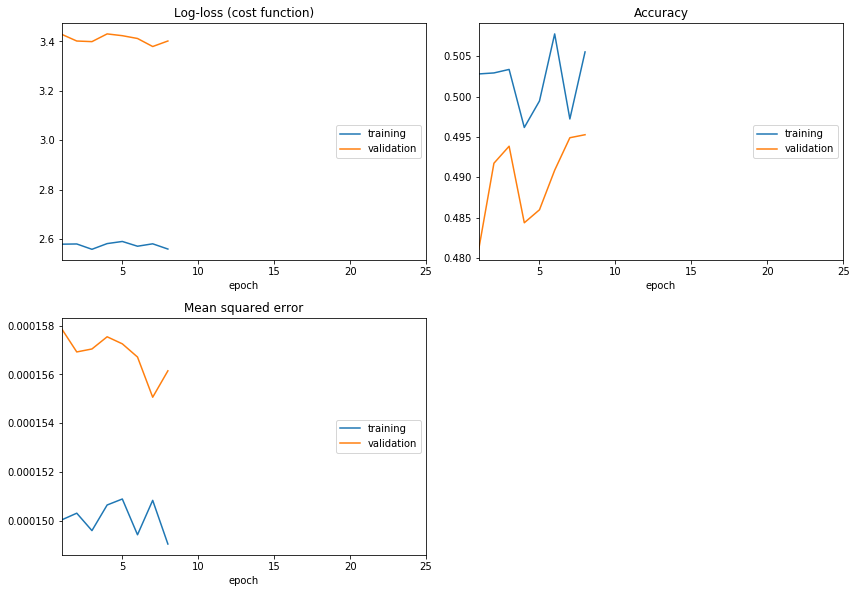

Epoch 9/25
186/252 [=====================>........] - ETA: 36s - loss: 2.5577 - acc: 0.5033 - mean_squared_error: 1.4903e-04

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from time import time

workers = 8

best_weights_path=f'whale.flukes.{num_classes}_classes.weights.best.hdf5'

# train the model
checkpointer = ModelCheckpoint(filepath=best_weights_path, verbose=1, save_best_only=True)

# Stop the training if the model shows no improvement 
stopper = EarlyStopping(monitor='val_loss', 
                        min_delta=0.005, 
                        patience=50, 
                        verbose=1, 
                        mode='auto')

# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                             factor=0.7,
                             patience=10,
                             min_lr=0.0000001,
                             verbose=1)

tensorboard = TensorBoard(log_dir="./logs/final/{}".format(time()),
                          batch_size=batch_size,
                          write_graph=True,
                          write_images=True,
                          histogram_freq=0,
                          write_grads=True)

model.fit_generator(generator=train_generator,
                    epochs=25,
                    steps_per_epoch = train_examples//batch_size,
                    validation_data=valid_generator, 
                    validation_steps = train_examples//batch_size,
                    callbacks=[checkpointer, stopper, reduce_lr,
                               PlotLossesKeras(), 
                               tensorboard],
                    verbose=1, workers=workers)

# Load the Model with the Best Validation Loss

In [27]:
from keras.models import load_model
model = load_model('whale.flukes.4250_classes.weights.best.hdf5')

# Calculate Classification Accuracy on Test Set

In [28]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    "data/test",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical', shuffle=False)

score = model.evaluate_generator(
    generator=test_generator)

print("Loss: ", score[0], "Accuracy: ", score[1])

scores = model.predict_generator(
    generator=test_generator)

Found 8836 images belonging to 4250 classes.
Loss:  2.8611668465417024 Accuracy:  0.5559076505205975


# Genegate confusion matrix

In [29]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_generator.classes, list(map(lambda x: np.argmax(x), scores)))

# Plot confusion matrix

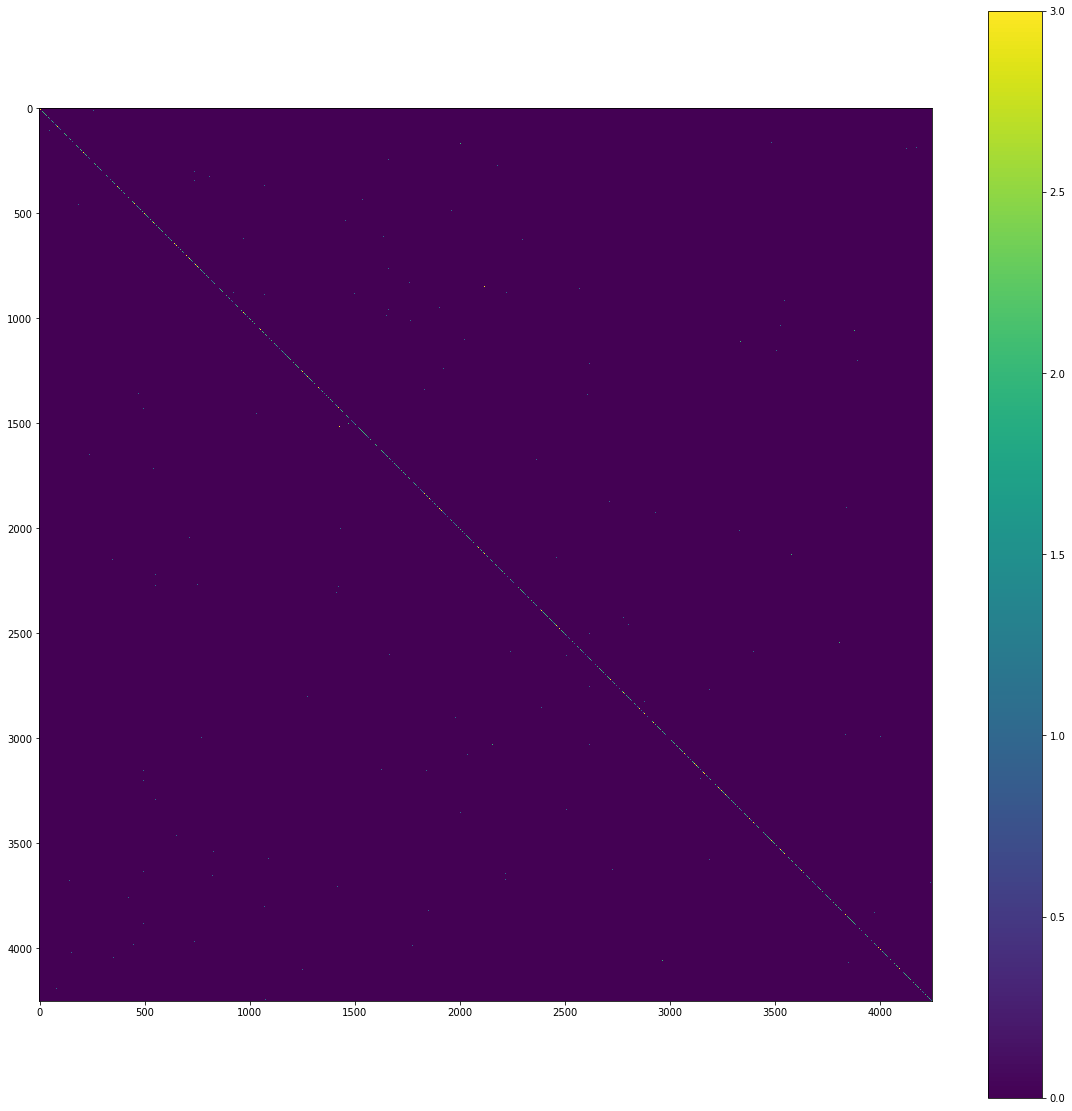

In [30]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_confusion_heatmap(cm):
    plt.imshow(cm, interpolation='none')
    plt.colorbar()
    
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
# plt.figure(figsize=(20,20))
# plot_confusion_matrix(cnf_matrix, classes=classes, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plt.figure(figsize=(20,20))
# plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.figure(figsize=(20, 20))
plot_confusion_heatmap(cnf_matrix)

plt.show()